In [98]:
# Enable auto-complete for notebook
%config IPCompleter.greedy=True

# Show plots directly in the notebook
%matplotlib inline

import pandas as pd
import numpy as np
import statsmodels.formula.api as sm # for training a linear regression model.
import matplotlib.pyplot as plt
import seaborn as sns # For making correlation matrices

# 1 - Prepare Data

In [99]:
# Read in results
df = pd.read_csv('combinedResults.csv', sep=';')

In [100]:
df.head(5)

,chartNumber,column,columnSize,correctColumn,correctColumnSize,duration,Participant
0,0,1,10,1,11,132.629580,participant1
1,21,3,25,3,31,32.749995,participant1
2,4,2,52,2,52,20.776342,participant1
3,18,1,12,1,10,35.804036,participant1
4,6,0,38,0,37,12.049216,participant1


In [101]:
# Dictionary containing {chartNumber: number of columns}
numberOfColumns = {1:3, 2:3, 3:3, 4:3, 5:3, 6:3, 7:3, 8:3, 
                   9:5, 10:5, 11:5, 12:5, 13:5, 14:5, 15:5, 16:5,
                   17:8, 18:8, 19:8, 20:8 , 21:8, 22:8, 23:8, 24:8,
                   0:5}

In [102]:
df["numDataPoints"] = [numberOfColumns[i] for i in df["chartNumber"].tolist()]

In [103]:
df.head(5)

,chartNumber,column,columnSize,correctColumn,correctColumnSize,duration,Participant,numDataPoints
0,0,1,10,1,11,132.629580,participant1,5
1,21,3,25,3,31,32.749995,participant1,8
2,4,2,52,2,52,20.776342,participant1,3
3,18,1,12,1,10,35.804036,participant1,8
4,6,0,38,0,37,12.049216,participant1,3


In [104]:
# Create dummy which is False (0) if participant got column correct, and True (1) if they got it wrong.
df["relativeEstimateDummy"] = (df["column"] != df["correctColumn"])

In [105]:
# Get absolute error of estimate
df["estimateError"] = abs(df["columnSize"] - df["correctColumnSize"])

In [106]:
# Get dummy for orientation. 1 = column chart, 0 = bar chart
df["orientation"] = df["chartNumber"] % 2

In [107]:
# Drop ALL the test charts. :(
df = df.drop(df[df["chartNumber"] == 0].index.tolist())

In [108]:
df.head(5)

,chartNumber,column,columnSize,correctColumn,correctColumnSize,duration,Participant,numDataPoints,relativeEstimateDummy,estimateError,orientation
1,21,3,25,3,31,32.749995,participant1,8,False,6,1
2,4,2,52,2,52,20.776342,participant1,3,False,0,0
3,18,1,12,1,10,35.804036,participant1,8,False,2,0
4,6,0,38,0,37,12.049216,participant1,3,False,1,0
5,17,1,9,1,10,20.745094,participant1,8,False,1,1


In [109]:
# Double check to make sure we aren't including the example charts...
df.loc[df["chartNumber"] == 0]

,chartNumber,column,columnSize,correctColumn,correctColumnSize,duration,Participant,numDataPoints,relativeEstimateDummy,estimateError,orientation


# 2 - Initial Findings

In [110]:
df[["columnSize", "correctColumnSize", "estimateError", "duration"]].describe().T

,count,mean,std,min,25%,50%,75%,max
columnSize,120.0,34.183333,19.883266,9.000000,18.75000,30.000000,44.250000,85.000000
correctColumnSize,120.0,34.083333,20.565363,10.000000,18.75000,30.000000,44.500000,85.000000
estimateError,120.0,1.250000,1.529816,0.000000,0.00000,1.000000,2.000000,9.000000
duration,120.0,15.574807,6.497189,7.435744,11.27468,13.770182,18.157962,43.630312


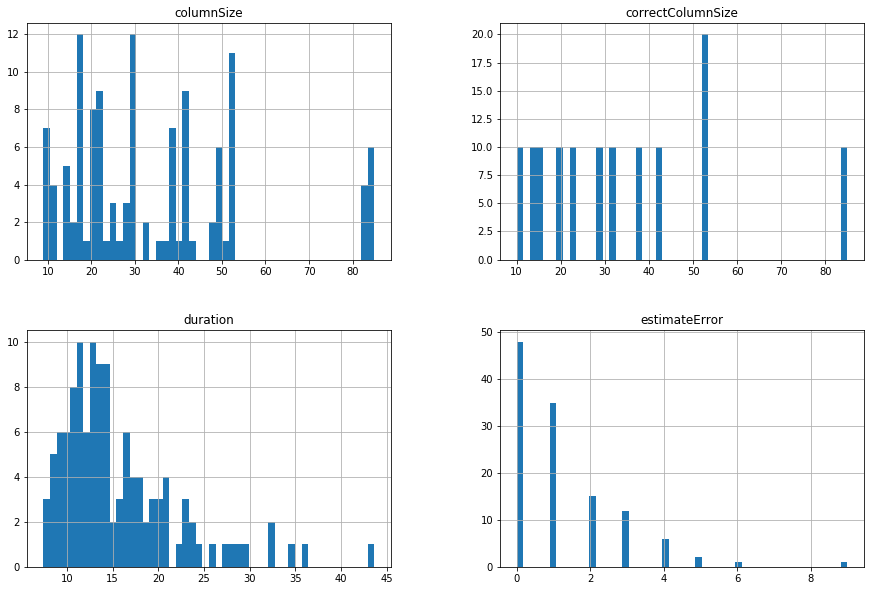

In [111]:
# Plot a histogram of duration.
df[["columnSize", "correctColumnSize", "estimateError", "duration"]].hist(figsize=(15,10), bins=50)
plt.show()

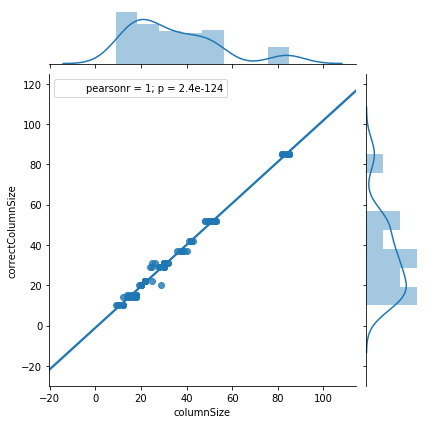

In [112]:
# Actual column size vs participant's estimates
sns.jointplot("columnSize", "correctColumnSize", data=df, kind="reg")

plt.show()

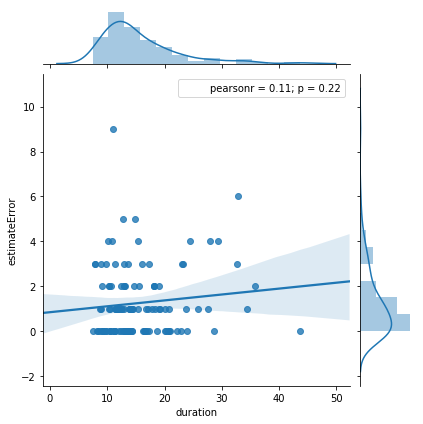

In [113]:
# Actual duration vs estimate error
sns.jointplot("duration", "estimateError", data=df, kind="reg")

plt.show()

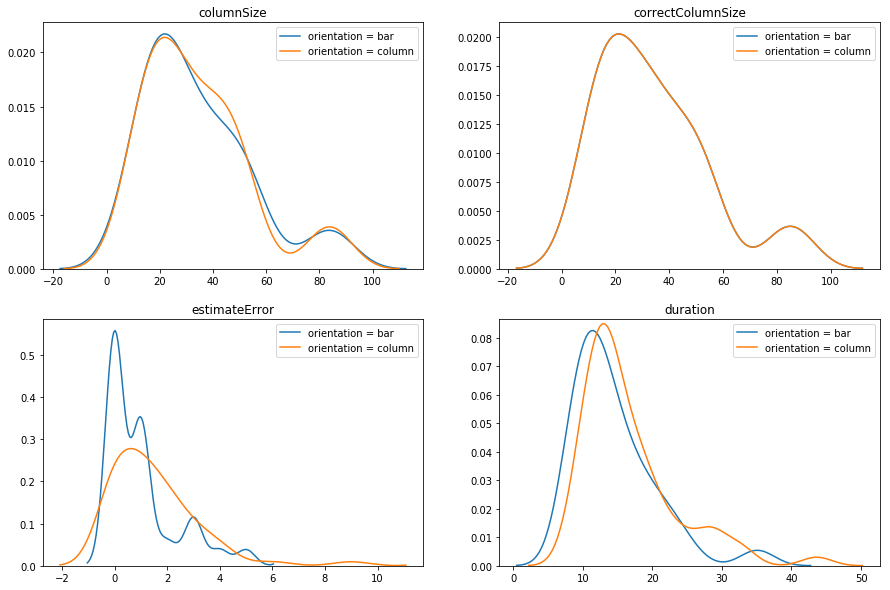

In [114]:
# Plots of disributions of the continuous variables where churn is either 0 or 1.

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes_list = [item for sublist in axes for item in sublist]

x = ["columnSize", "correctColumnSize", "estimateError", "duration"]

for feature in x:
    ax = axes_list.pop(0)

    sns.distplot(df[df['orientation'] == False][[feature]], hist=False, ax=ax, label="orientation = bar")
    sns.distplot(df[df['orientation'] == True][[feature]], hist=False, ax=ax, label="orientation = column")
        
    ax.set_title(feature)

for ax in axes_list:
    ax.remove()     
    
plt.show()

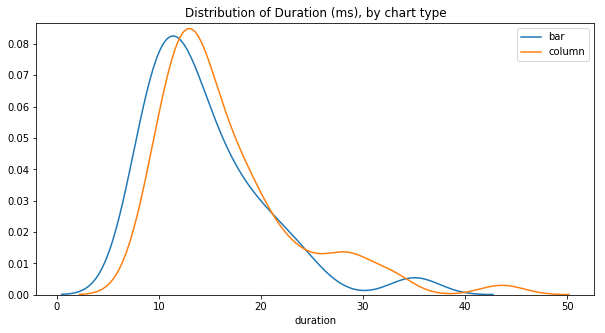

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

sns.distplot(df[df['orientation'] == False]["duration"], hist=False, ax=ax, label="bar")
sns.distplot(df[df['orientation'] == True]["duration"], hist=False, ax=ax, label="column")

ax.set_title("Distribution of Duration (ms), by chart type")

plt.show()

# 3 - Run Models

In [116]:
# Regress explanatory variables on duraction
linearModel = sm.ols(formula="duration ~ orientation + Participant + numDataPoints", data=df).fit()
print(linearModel.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     5.766
Date:                Sat, 17 Nov 2018   Prob (F-statistic):           2.89e-05
Time:                        14:41:33   Log-Likelihood:                -378.31
No. Observations:                 120   AIC:                             770.6
Df Residuals:                     113   BIC:                             790.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [117]:
# Regress explanatory variables on estimateError
linearModel = sm.ols(formula="estimateError ~ orientation + Participant + numDataPoints", data=df).fit()
print(linearModel.summary())

                            OLS Regression Results                            
Dep. Variable:          estimateError   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     3.907
Date:                Sat, 17 Nov 2018   Prob (F-statistic):            0.00139
Time:                        14:41:33   Log-Likelihood:                -209.48
No. Observations:                 120   AIC:                             433.0
Df Residuals:                     113   BIC:                             452.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         